# Project balanced UMAP
Here, we balanced segment dataset (created in the previous step) will be projected into latent space using UMAP.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

In [2]:
import avgn

In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir, FIGURE_DIR
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig

In [4]:
DATASET_ID = "git_repos"

In [5]:
DT_ID = '2022-03-04_18-41-29'

## Import Pickle & Run UMAP Analyses

In [6]:
seg_df = pd.read_pickle(DATA_DIR / DATASET_ID / 'segmentdf_for_UMAP_balanced.pickle')
seg_df[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,group,location,sex,wav_loc,key,rate,specs,comb_labels,call_lab_simp,combi_lab_simp
3,0.338289,0.439778,NL,26,0.338289,0.439778,NLSHDS,0.338289,0,11,...,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Excitement 2 170519 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NL,NL-SH-DS,DS-SH-DS NL-SH-DS
0,0.020744,0.165861,NL,29,0.020744,0.165861,NLDS,0.020744,0,12,...,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,MGGY Alarm Alert series 1 100717,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NL,NL-DS,NL-DS DS-SH-DS SH-LH
3,0.349618,0.443789,NL,51,0.349618,0.443789,NLSHDS,0.349618,0,20,...,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,MGGY Alert 2 070817,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NL,NL-SH-DS,DS-SH-DS NL-SH-DS SH-DS LH


In [7]:
len(seg_df)

692

BMYO 41


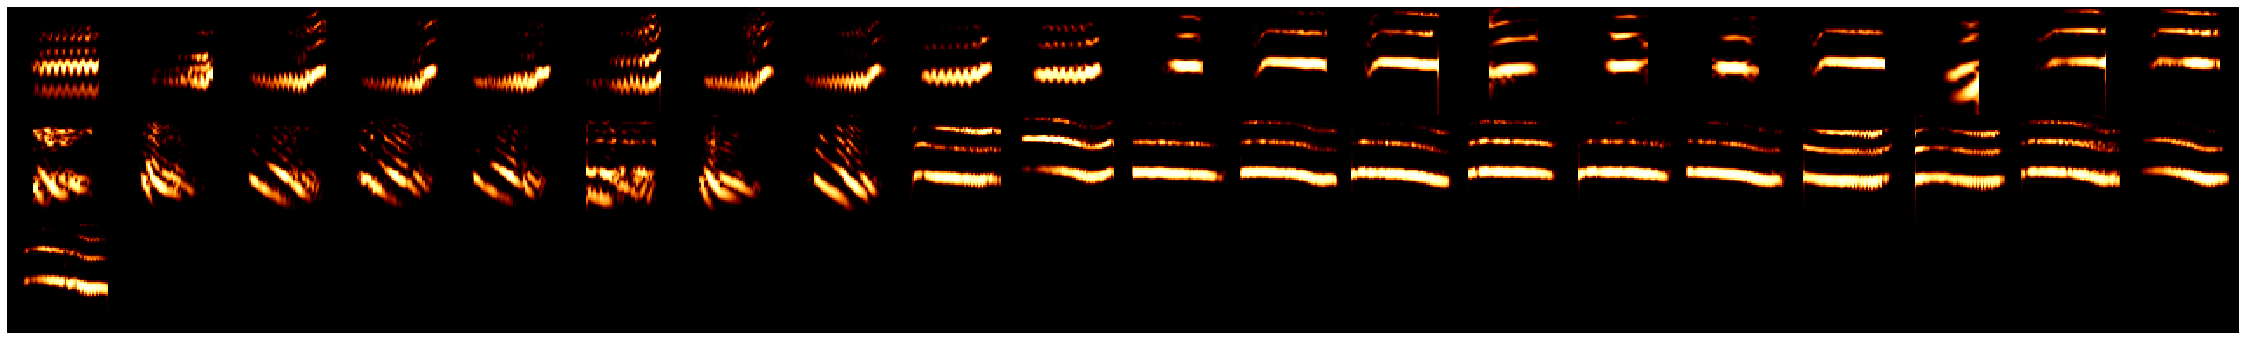

GBYM 47


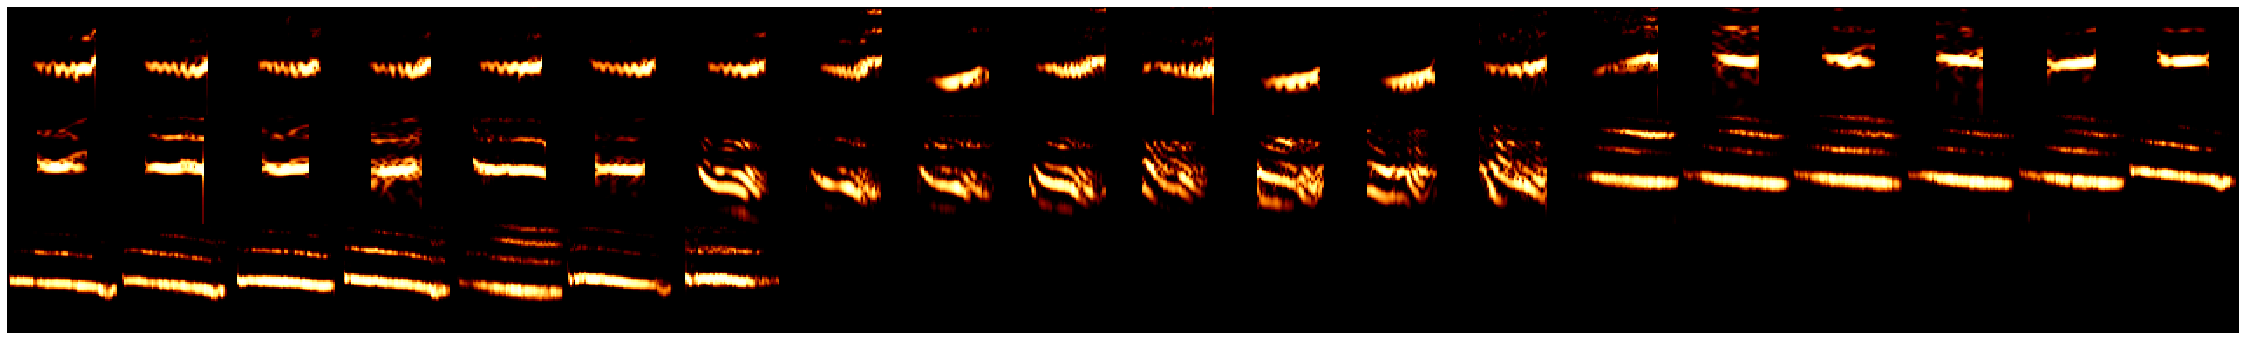

GON XF 19-21 26


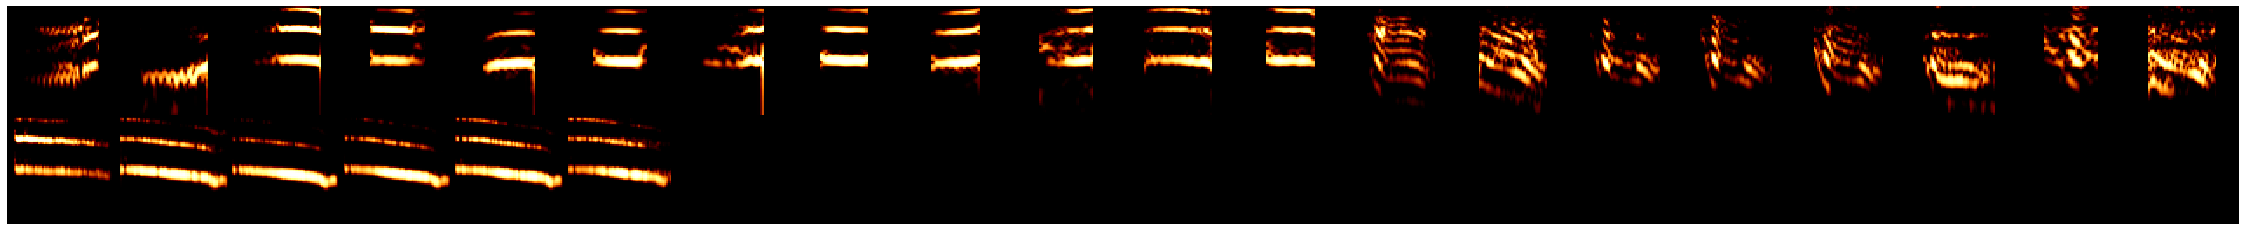

GON XM 20-21 10


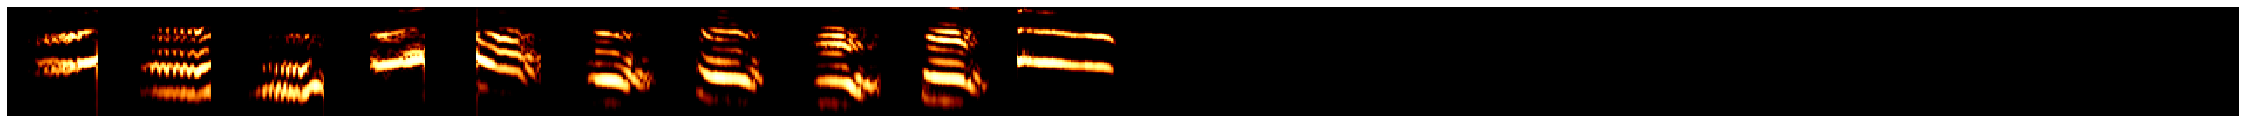

MGGY 38


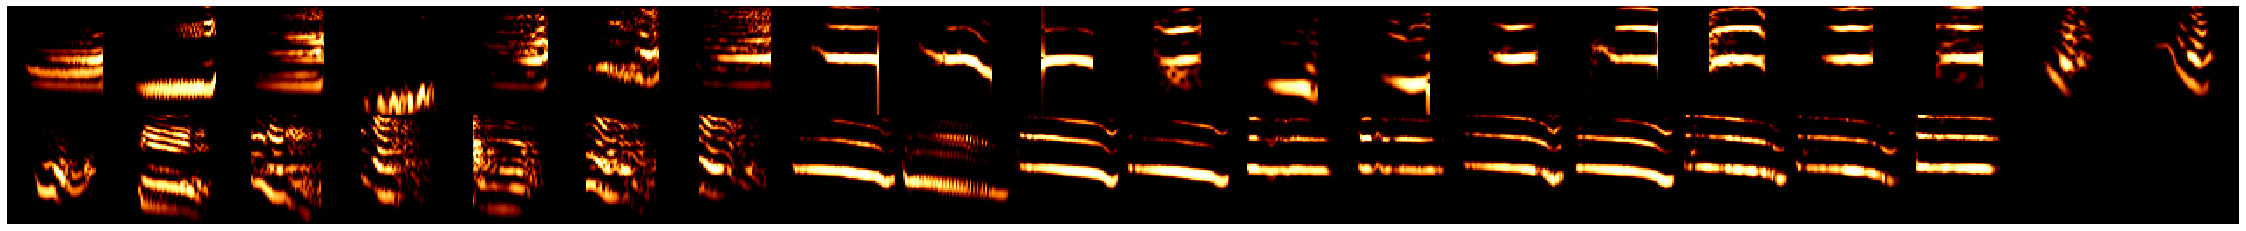

MOGO 45


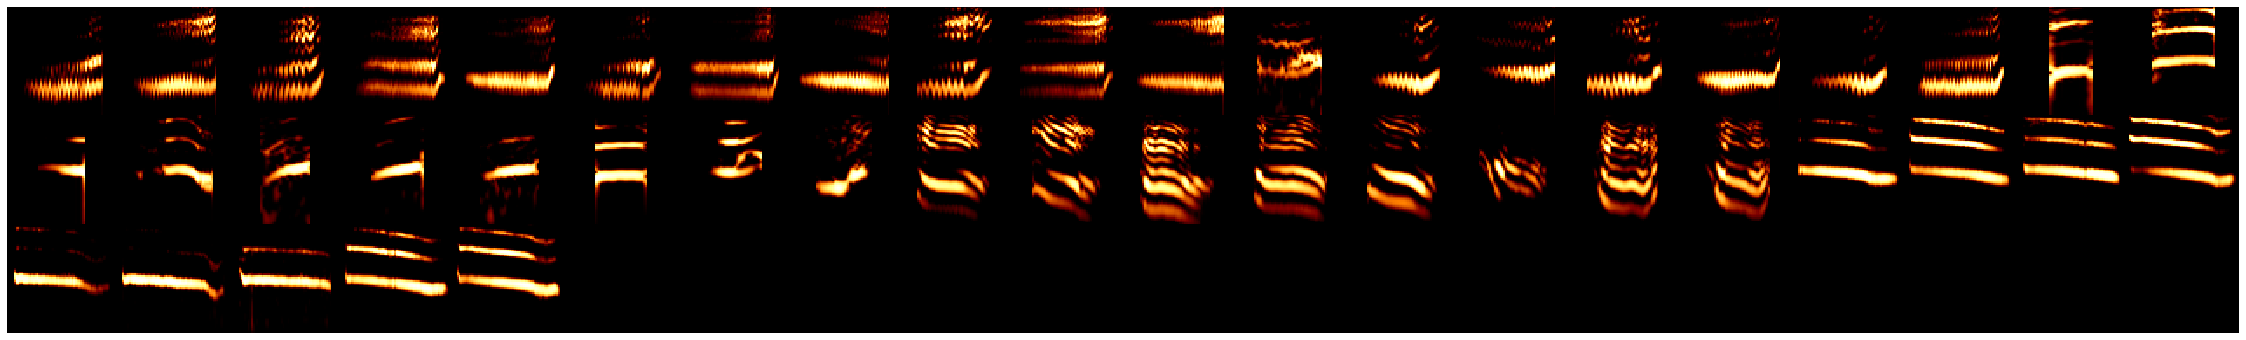

MOOO 24


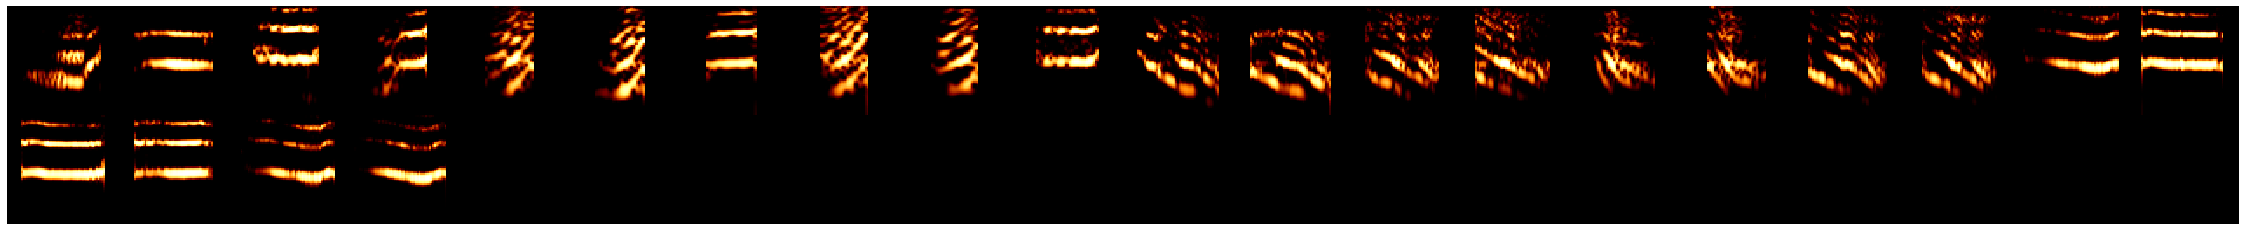

MORP 15


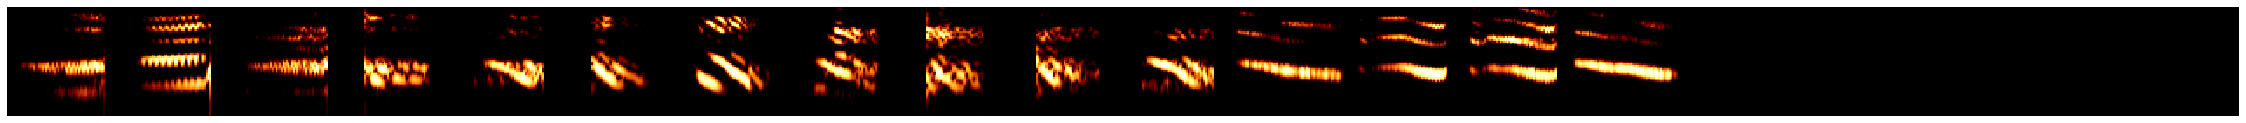

MOVY 19


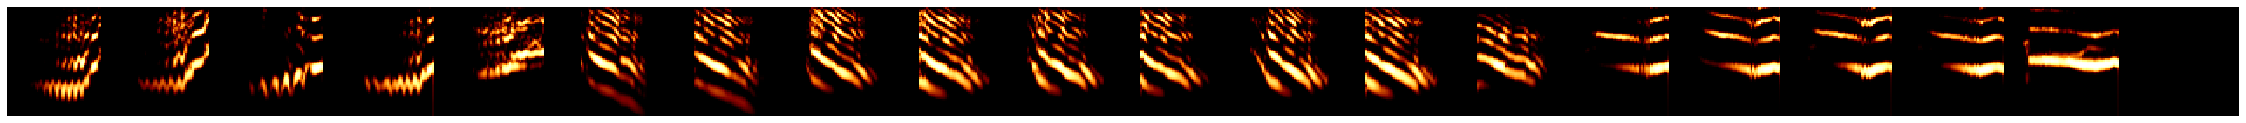

MRGO 40


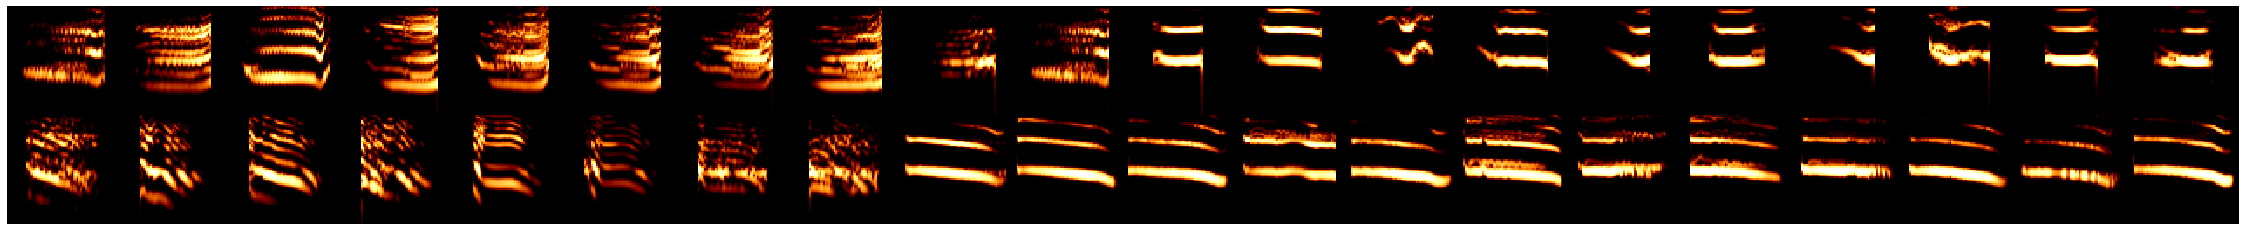

MXWW 30


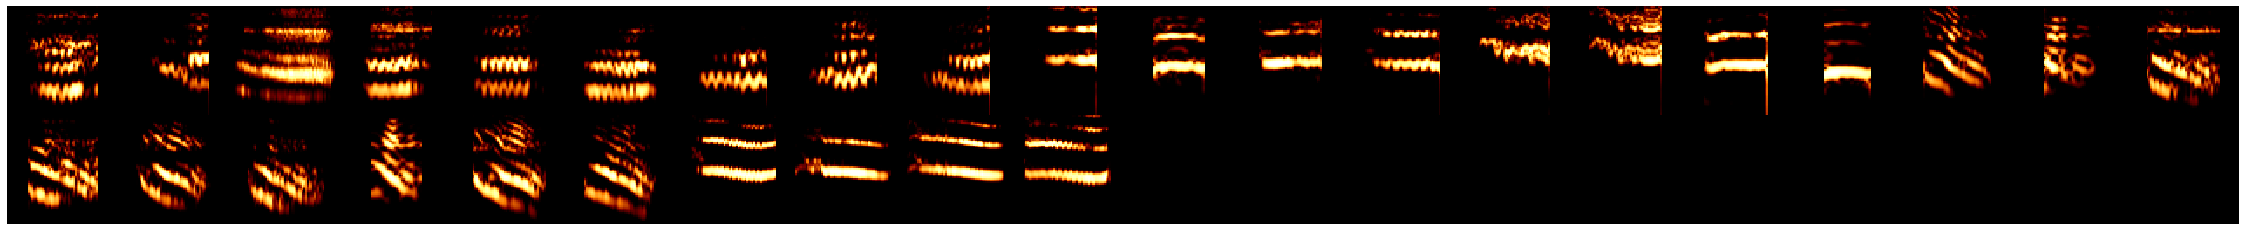

MXXBYX 3


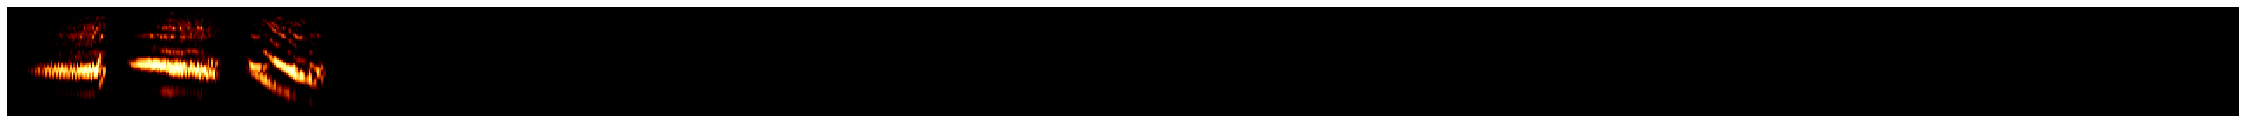

MXXGRY 42


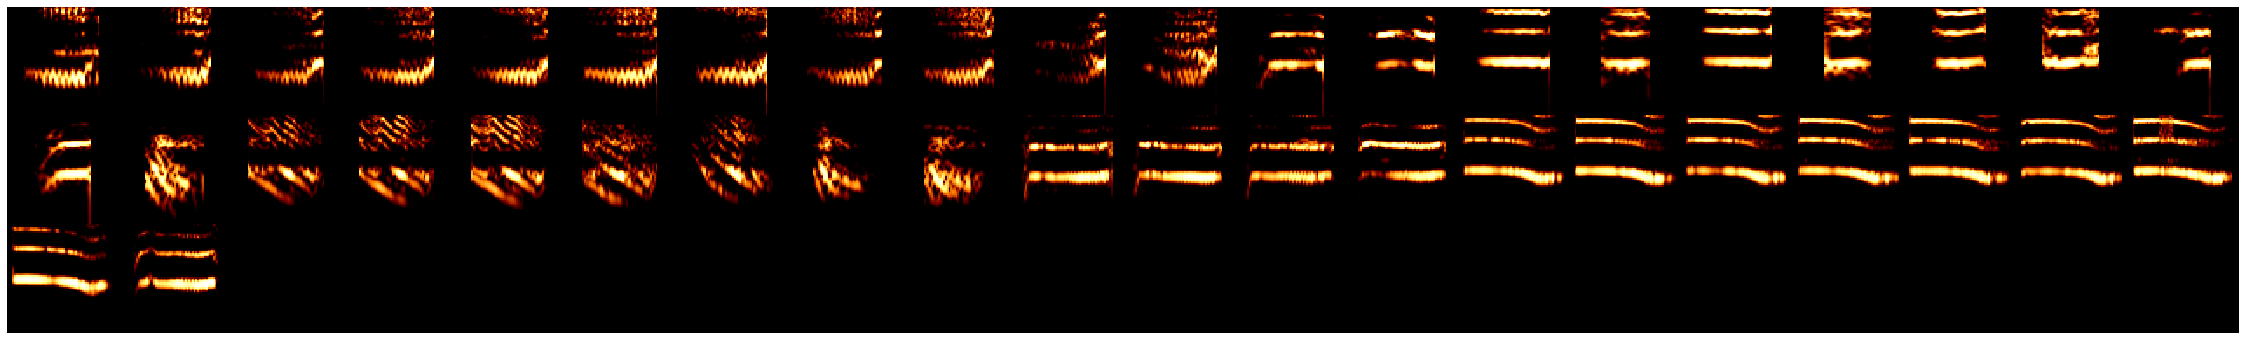

OMGO 42


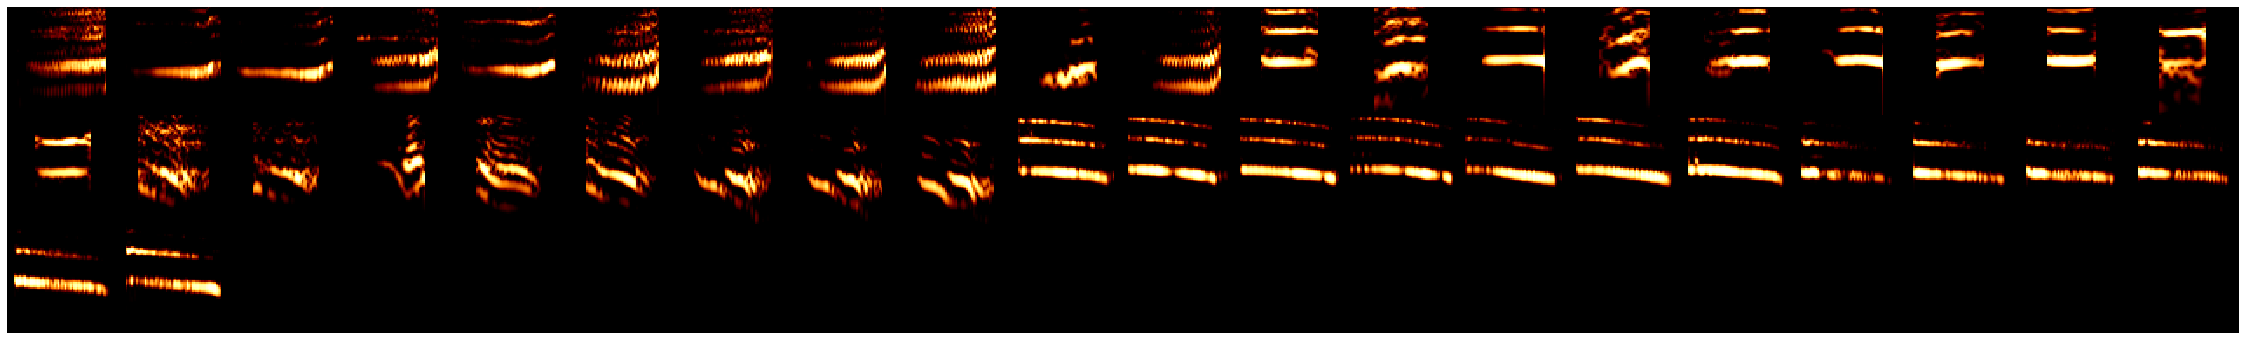

PMXRMX 19


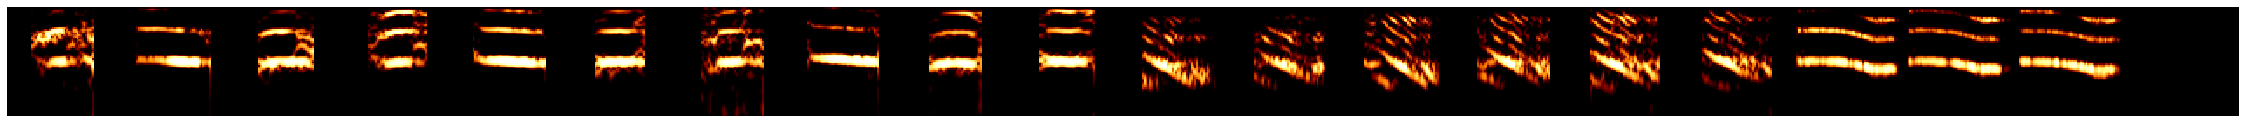

RMXGMX 48


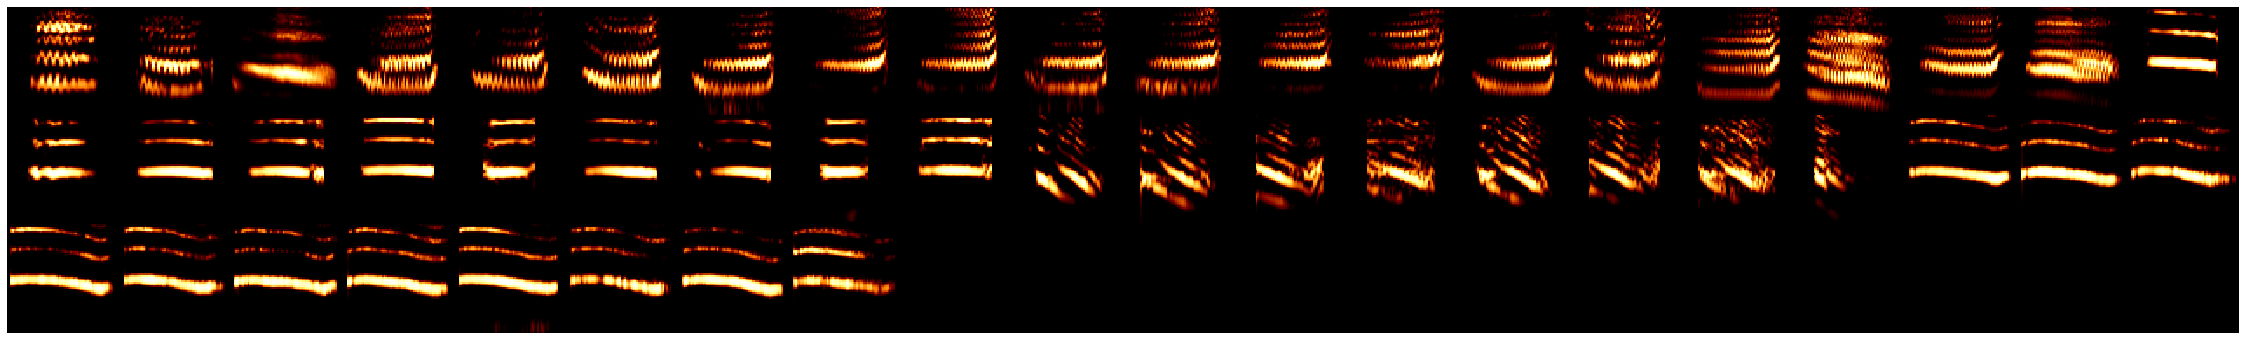

RMYG 34


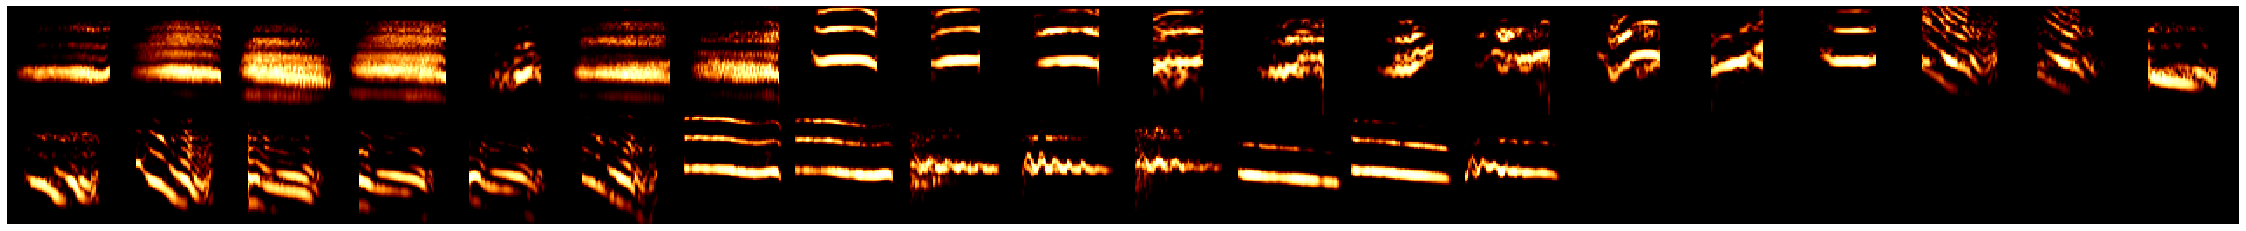

RYMR 11


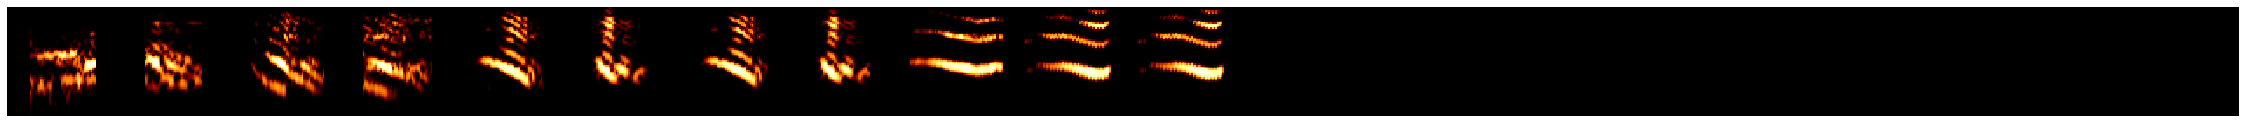

SCL XF 20-21 32


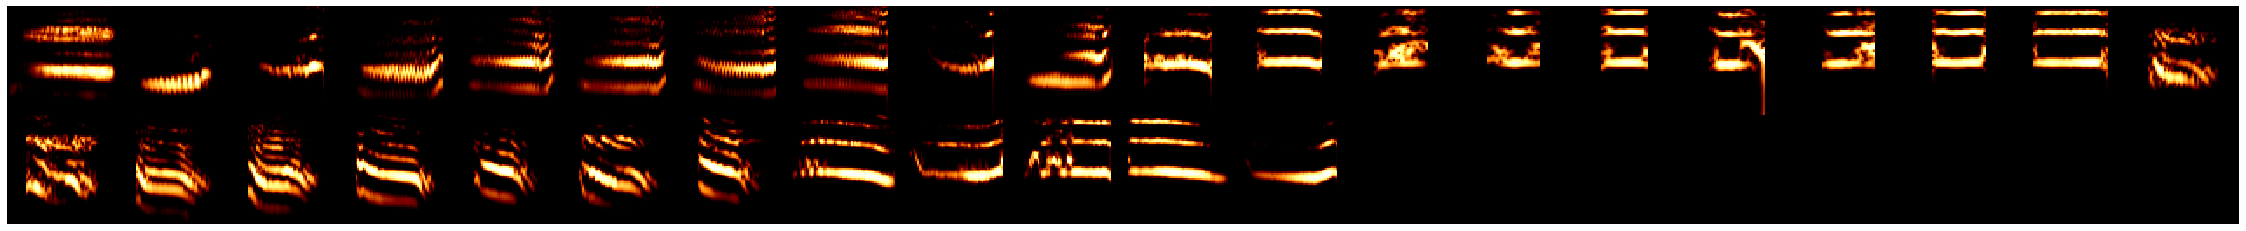

SCL XM 20-21 16


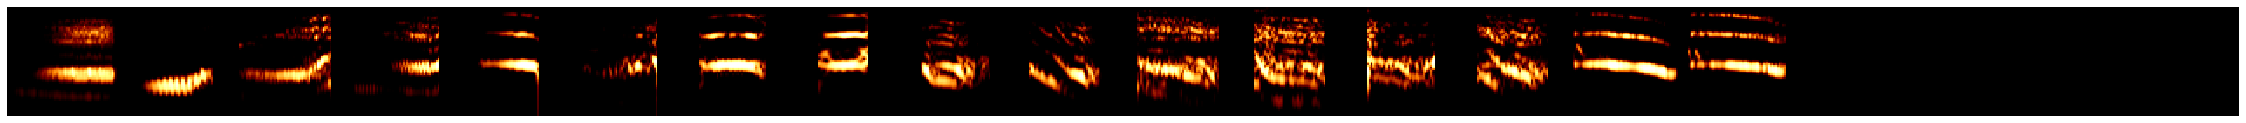

VVOM 32


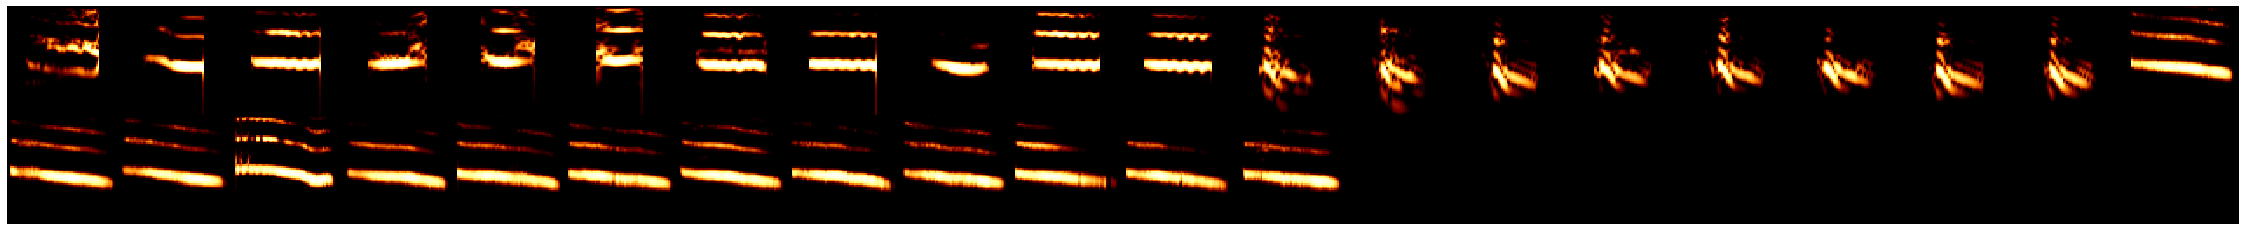

VVVM 53


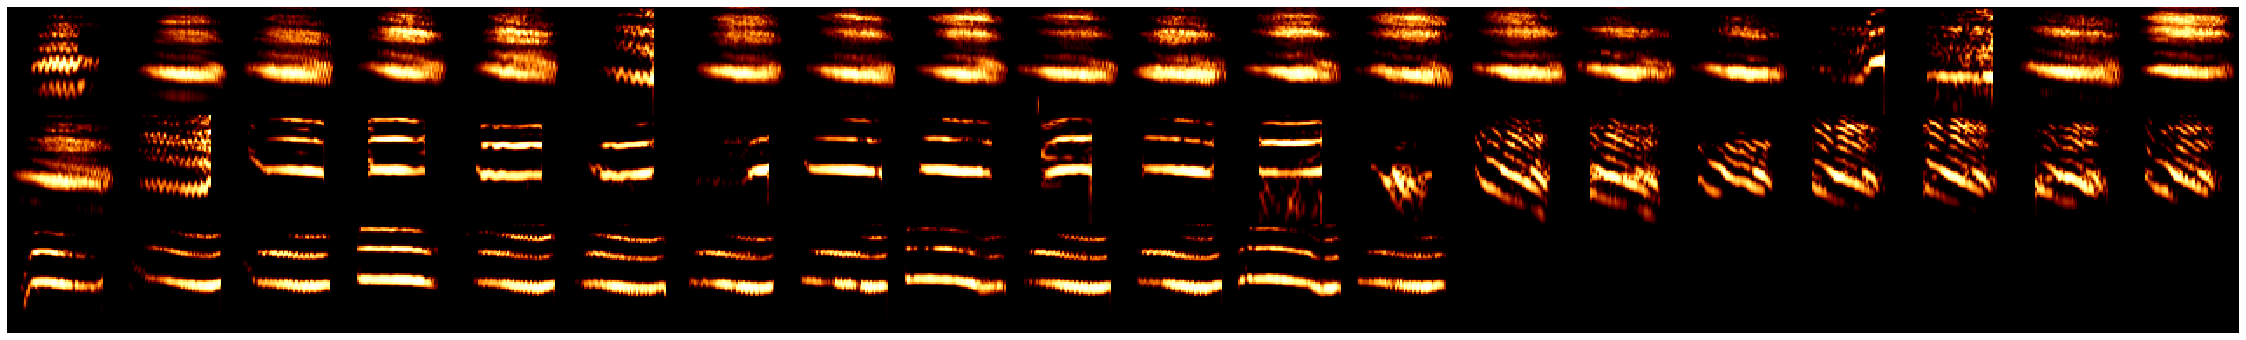

XF 20-21 25


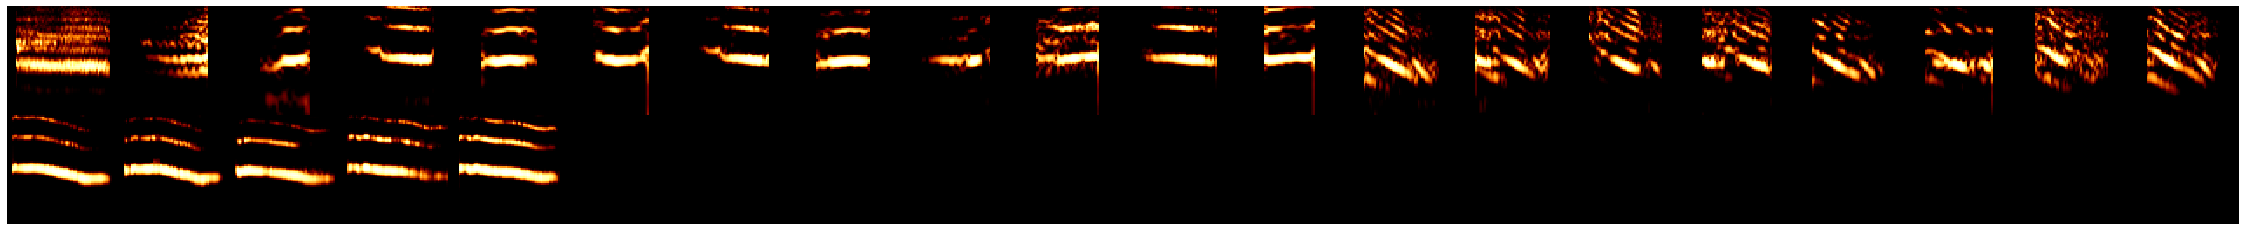

In [13]:
for indv in np.sort(seg_df.indv.unique()[:]):
    print(indv, np.sum(seg_df.indv == indv))
    specs = np.array([i/np.max(i) for i in seg_df[seg_df.indv == indv].spectrogram.values])
    specs[specs<0] = 0
    
    draw_spec_set(specs, zoom=2,
                  maxrows=8, 
                  colsize=20)
    plt.show()

### Spectrograms for all individuals

In [14]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [15]:
seg_df = seg_df[np.array([np.sum(i) > 0.0 for i in seg_df.specs.values])
]

In [16]:
specs = list(seg_df.specs.values)
specs = [norm(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

  0%|          | 0/692 [00:00<?, ?it/s]

(692, 4096)

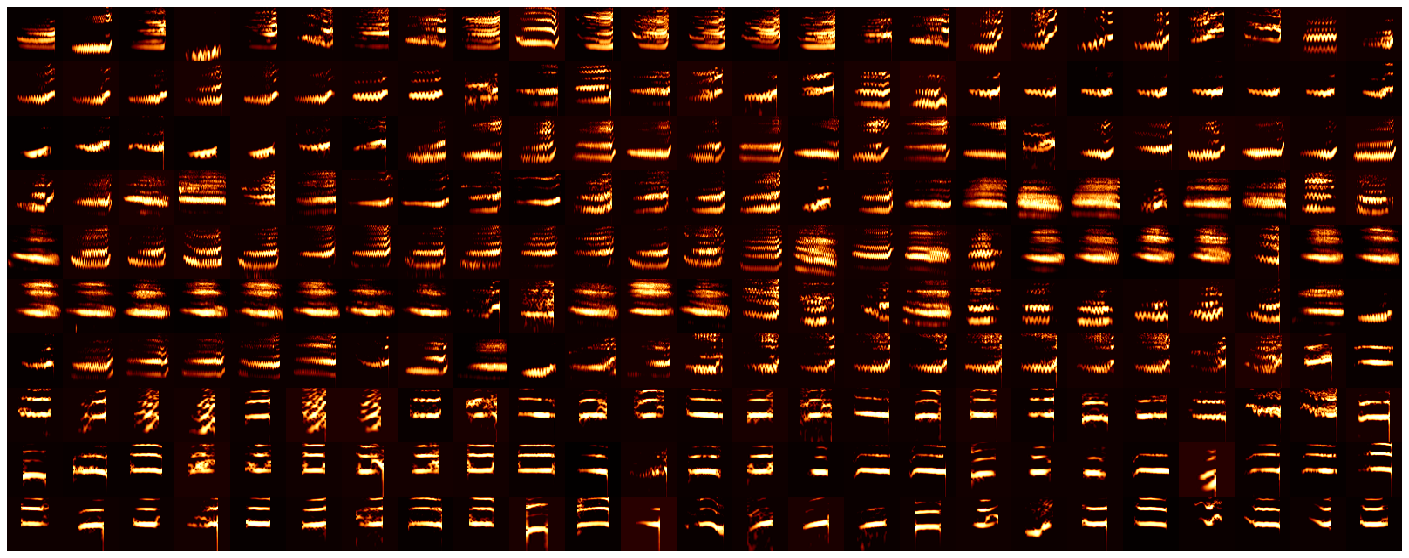

In [17]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

In [18]:
fit = umap.UMAP(min_dist=0.0, verbose = True)
z = list(fit.fit_transform(specs_flattened))

UMAP(min_dist=0.0, verbose=True)
Construct fuzzy simplicial set
Wed Aug 17 13:30:29 2022 Finding Nearest Neighbors
Wed Aug 17 13:30:30 2022 Finished Nearest Neighbor Search
Wed Aug 17 13:30:32 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Aug 17 13:30:34 2022 Finished embedding


In [ ]:
nex = -1
scatter_spec(
    z,
    specs,
    column_size=12,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.comb_labels.values,
        'alpha':1,
        's': 5,
        'show_legend': True,
        "color_palette": 'colorblind',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);

In [20]:
seg_df['umap'] = list(z)

## Export pickle

In [22]:
#save df
save_loc = DATA_DIR / DATASET_ID /  'UMAP_balanced_df.pickle'
ensure_dir(save_loc.as_posix())
seg_df.to_pickle(save_loc)